In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
# import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from  sklearn.ensemble import RandomForestClassifier
from scipy import stats
# from sklearn.cluster import OPTICS
from copy import deepcopy

from scipy.stats import zscore
from scipy.spatial import distance


plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


In [2]:
# load light curve segments
with open('{}/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-24_13-14-02.h5"
segments_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 20 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [474471, 24]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [3]:
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [4]:
with open('{}/lightcurve1738_train70_val10_test20.pkl'.format(data_dir), 'rb') as f:
    split_ob_ids = pickle.load(f)

In [5]:
with open('{}/474471_len128_stride10_1sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

In [6]:
# Load Gaussian mixture model which produced the minimum BIC with 1 second cadence data
with open("{}/GMM_222comps_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir), 'rb') as f:
    GMmodel_1s = pickle.load(f)

# find clusters for the data
GMmodel_1s_labels = GMmodel_1s.predict(shape_moments)

In [7]:
# calculate mahalanobis distances between components
# GM_comp_mahal_distances_1s = component_mahalanobis_distances(GMmodel_1s)

# with open("GM_comp_mahal_distances_1s.pkl", 'wb') as f:
#     pickle.dump(GM_comp_mahal_distances_1s, f)

with open('GM_comp_mahal_distances_1s.pkl', 'rb') as f:
    GM_comp_mahal_distances_1s = pickle.load(f)

In [8]:
def grid_search_classification_mu_shuffling(data_labels, data, train_set_ids, val_set_ids, seg_ObIDs):
    """
    prepare representations of observations based on their make up in terms of Gaussian mixture component contributions.
    test the representation as the feature set for classification task
    """
        
    # find GMM component labels for data
    data_GMMcomp_labels = data_labels
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)
        
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    
    
    obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows
    
    # add classification column
    obs_component_counts_df_comp["Class"] = "Unknown" 
    for k,v in ob_state.items():
        if v == "eta": v = "Unknown" ########## remove eta classifications, there are only two in the set of 1738 observations
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            
    obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"
    
    
    # create sets of shuffled (in as stratified manner) training and validaiton data 
    class_names, class_counts = np.unique(obs_component_counts_df_comp.loc[val_set_ids].loc[obs_component_counts_df_comp.loc[val_set_ids].iloc[:,-1] != "Unknown"].Class.values, return_counts=True)
    validation_sets = []
    training_sets = []

    for repetition in range(100):
        validation_set = []
        training_set = []
        for class_name, class_count in zip(class_names, class_counts):
            subset_ids = np.hstack((val_set_ids, train_set_ids))
            class_ids = obs_component_counts_df_comp.loc[subset_ids].loc[obs_component_counts_df_comp.loc[subset_ids].iloc[:,-1] == class_name].index.values
            np.random.seed(seed=repetition)
            validation_ids = np.random.choice(class_ids, size=class_count, replace=False)
            training_ids = np.array([x for x in class_ids if x not in validation_ids])

            validation_set.append(validation_ids)
            training_set.append(training_ids)

        validation_sets.append(np.concatenate(validation_set))
        training_sets.append(np.concatenate(training_set))

    #random forest hyperparameters
    max_depth_list = [None, 5, 10, 15, 25] # None 
    criterion_list= ["entropy", 'gini']

    reports = []
    
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for train_ids, val_ids in zip(training_sets, validation_sets):
                
                # training data
                train_data = obs_component_counts_df_comp.loc[train_ids] 
                # validation data
                val_data = obs_component_counts_df_comp.loc[val_ids]
                                
                RF_clf = RandomForestClassifier(random_state=0,
                                                criterion=criterion,
                                                class_weight="balanced",
                                                n_estimators=100,
                                                max_depth=max_depth, 
                                                min_samples_split= 2,
                                                min_samples_leaf = 1,
                                                n_jobs=35
                                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
                preds = RF_clf.predict(val_data.iloc[:,:-1])

                reports.append((precision_recall_fscore_support(val_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2],
                                accuracy_score(val_data.iloc[:,-1], preds),
                               (criterion,max_depth)))
    return reports

def merge_gaussian_component_labels(distance_matrix, observation_labels, sigma_threshold):
    """
        if mahalanobis distance between Gaussian components is smaller than the sigma_threshold, relabel the data within
    those components as belonging to a new, single cluster
    
    input:
        distance_matrix - square matrix containing distances between Gaussian component means, output of component_mahalanobis_distances function
        observation_labels - list of data labels corresponding to the Gaussian components
        sigma_threshold - threshold for the merger of Gaussian components. If distances between two component means are less then the threshold,
        (both when calculating from A to B and from B to A), the components will be treated as one cluster.
                            
    output
        new_observation_labels - modified observation_labels, where a new index was created for merged components, and both component indices were
        replaced with that new index
    

    uses the graph solution from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
    """
    # find pairs of components whose means are separated by mahalanobis distance smaller than the threshold (both ways)
    couples = np.array(np.where(((np.triu(distance_matrix)<sigma_threshold)&(np.triu(distance_matrix)>0))
      &(np.triu(distance_matrix.T)<sigma_threshold)&(np.triu(distance_matrix.T)>0))).T
    
    # build a graph of connections
    l = []
    for couple in couples:
        l.append([str(c) for c in couple])
    import networkx 
    from networkx.algorithms.components.connected import connected_components
    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G
    def to_edges(l):
        """ 
            treat `l` as a Graph and returns it's edges 
            to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current    
    G = to_graph(l)

    new_observation_labels = observation_labels
    # merge components
    for n_connection, connection in enumerate(connected_components(G)):
        node_indices=np.array([int(node) for node in connection])
#         new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
#                                           n_connection+np.unique(observation_labels).shape[0], new_observation_labels)
        new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
                                          node_indices[0], new_observation_labels)
        
    return new_observation_labels


In [11]:
no_components_premerger = np.unique(GMmodel_1s_labels).shape[0]

sigma_reports_list = []

for sigma_threshold in np.linspace(1.5,5,100):
    data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, sigma_threshold)
    if (np.unique(data_labels).shape[0] < no_components_premerger) or len(sigma_reports_list)==0:
        no_components_premerger = np.unique(data_labels).shape[0]
        reports = grid_search_classification_mu_shuffling(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[1], seg_ObIDs)
        sigma_reports_list.append((sigma_threshold, reports))
        print(len(sigma_reports_list), sigma_threshold)
        clear_output(wait=True)
        
with open("sigmas100_reports_list_1s_100rng_criterion_depth_fixed_mergers_mu_withshuffling.pkl", 'wb') as f:
    pickle.dump(sigma_reports_list, f)

60 5.0


In [12]:
rng_iterations= 100
treshold_avg_reports=[]
for threshold, report_list in sigma_reports_list:
    average_reports = []
    for set_i in range(int(len(report_list)/rng_iterations)):
        avg_f1=0
        avg_ac=0
        for rng_i in range(rng_iterations):
            avg_f1 += report_list[rng_i+(set_i*rng_iterations)][0]
            avg_ac += report_list[rng_i+(set_i*rng_iterations)][1]
        average_reports.append((avg_f1/rng_iterations,avg_ac/rng_iterations,(report_list[set_i*rng_iterations][2])))
    treshold_avg_reports.append((threshold,average_reports))

In [13]:
best_f1 = 0
best_result = []
for threshold, report_list in treshold_avg_reports:
    for report in report_list:
        if report[0] > best_f1:
            best_f1 = report[0]
            best_result = [threshold, report]
best_result

[3.3383838383838382, (0.813872309508673, 0.8540909090909081, ('gini', 5))]

In [26]:
best_reports = sigma_reports_list[28][1][600:700]
(np.mean([x for x,y,z in best_reports]), np.std([x for x,y,z in best_reports]),
np.mean([y for x,y,z in best_reports]), np.std([y for x,y,z in best_reports]))

(0.8138723095086731,
 0.06466732382905516,
 0.8540909090909089,
 0.05389575183737305)

In [9]:
np.unique(merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.34)).shape

(150,)

# test the best classifier

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
# import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from  sklearn.ensemble import RandomForestClassifier
from scipy import stats
# from sklearn.cluster import OPTICS
from copy import deepcopy

from scipy.stats import zscore
from scipy.spatial import distance


plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


In [2]:
# load light curve segments
with open('{}/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-24_13-14-02.h5"
segments_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 20 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [474471, 24]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [3]:
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [4]:
with open('{}/lightcurve1738_train70_val10_test20.pkl'.format(data_dir), 'rb') as f:
    split_ob_ids = pickle.load(f)

In [5]:
with open('{}/474471_len128_stride10_1sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

In [6]:
# Load Gaussian mixture model which produced the minimum BIC with 1 second cadence data
with open("{}/GMM_222comps_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir), 'rb') as f:
    GMmodel_1s = pickle.load(f)

# find clusters for the data
GMmodel_1s_labels = GMmodel_1s.predict(shape_moments)

In [7]:
# calculate mahalanobis distances between components
# GM_comp_mahal_distances_1s = component_mahalanobis_distances(GMmodel_1s)

# with open("GM_comp_mahal_distances_1s.pkl", 'wb') as f:
#     pickle.dump(GM_comp_mahal_distances_1s, f)

with open('GM_comp_mahal_distances_1s.pkl', 'rb') as f:
    GM_comp_mahal_distances_1s = pickle.load(f)

In [8]:
def merge_gaussian_component_labels(distance_matrix, observation_labels, sigma_threshold):
    """
        if mahalanobis distance between Gaussian components is smaller than the sigma_threshold, relabel the data within
    those components as belonging to a new, single cluster
    
    input:
        distance_matrix - square matrix containing distances between Gaussian component means, output of component_mahalanobis_distances function
        observation_labels - list of data labels corresponding to the Gaussian components
        sigma_threshold - threshold for the merger of Gaussian components. If distances between two component means are less then the threshold,
        (both when calculating from A to B and from B to A), the components will be treated as one cluster.
                            
    output
        new_observation_labels - modified observation_labels, where a new index was created for merged components, and both component indices were
        replaced with that new index
    

    uses the graph solution from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
    """
    # find pairs of components whose means are separated by mahalanobis distance smaller than the threshold (both ways)
    couples = np.array(np.where(((np.triu(distance_matrix)<sigma_threshold)&(np.triu(distance_matrix)>0))
      &(np.triu(distance_matrix.T)<sigma_threshold)&(np.triu(distance_matrix.T)>0))).T
    
    # build a graph of connections
    l = []
    for couple in couples:
        l.append([str(c) for c in couple])
    import networkx 
    from networkx.algorithms.components.connected import connected_components
    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G
    def to_edges(l):
        """ 
            treat `l` as a Graph and returns it's edges 
            to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current    
    G = to_graph(l)

    new_observation_labels = observation_labels
    # merge components
    for n_connection, connection in enumerate(connected_components(G)):
        node_indices=np.array([int(node) for node in connection])
#         new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
#                                           n_connection+np.unique(observation_labels).shape[0], new_observation_labels)
        new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
                                          node_indices[0], new_observation_labels)
        
    return new_observation_labels


In [14]:
# [3.3383838383838382, (0.813872309508673, 0.8540909090909081, ('gini', 5))]
results = []


data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.34)
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v
obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"


# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]

np.random.seed(seed=11)
for test_iter in range(1000):

    RF_clf = RandomForestClassifier(random_state=test_iter,
                                    class_weight="balanced",
                                    criterion = 'gini',
                                    n_estimators=1000,
                                    max_depth=5, 
                                    min_samples_split=2,
                                    min_samples_leaf = 1,
                                    n_jobs=35
                                   ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
    preds = RF_clf.predict(test_data.iloc[:,:-1])

    results.append((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))
    print(len(results))
    clear_output(wait=True)

1000


In [16]:
# with open("test_results_gini_depth5_mahal3-34_1000rng_mu_withshuffling.pkl", 'wb') as f:
#     pickle.dump(results, f)

In [19]:
results

[(0.8723404255319149, 0.8936170212765957),
 (0.8336879432624115, 0.851063829787234),
 (0.8582742316784872, 0.8723404255319149),
 (0.8336879432624115, 0.851063829787234),
 (0.8723404255319149, 0.8936170212765957),
 (0.8984410236297677, 0.9148936170212766),
 (0.879888551165147, 0.8936170212765957),
 (0.879888551165147, 0.8936170212765957),
 (0.8522404157270321, 0.8723404255319149),
 (0.879888551165147, 0.8936170212765957),
 (0.879888551165147, 0.8936170212765957),
 (0.8723404255319149, 0.8936170212765957),
 (0.9185410334346504, 0.9361702127659575),
 (0.9185410334346504, 0.9361702127659575),
 (0.879888551165147, 0.8936170212765957),
 (0.8336879432624115, 0.851063829787234),
 (0.879888551165147, 0.8936170212765957),
 (0.8336879432624115, 0.851063829787234),
 (0.8336879432624115, 0.851063829787234),
 (0.879888551165147, 0.8936170212765957),
 (0.879888551165147, 0.8936170212765957),
 (0.9185410334346504, 0.9361702127659575),
 (0.8336879432624115, 0.851063829787234),
 (0.879888551165147, 0.89

In [15]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

0.8775646223485962 0.026929357102526127 0.8943617021276595 0.027145592737499166


In [60]:
np.argmin(np.absolute(np.array([x for x,y in results])-np.mean([x for x,y in results])))

60

In [61]:
np.argmax(np.array([x for x,y in results]))

12

In [65]:
plt.hist(np.array([x for x,y in results]))
# plt.show()

(array([166.,   0., 121.,   0., 147., 256.,   1., 130.,   0., 179.]),
 array([0.83368794, 0.84217325, 0.85065856, 0.85914387, 0.86762918,
        0.87611449, 0.8845998 , 0.89308511, 0.90157042, 0.91005572,
        0.91854103]),
 <BarContainer object of 10 artists>)

In [66]:
np.random.seed(seed=11)

RF_clf = RandomForestClassifier(random_state=2,
                                class_weight="balanced",
                                criterion = 'gini',
                                n_estimators=1000,
                                max_depth=5, 
                                min_samples_split=2,
                                min_samples_leaf = 1,
                                n_jobs=35
                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
preds = RF_clf.predict(test_data.iloc[:,:-1])

print((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))

(0.8582742316784872, 0.8723404255319149)


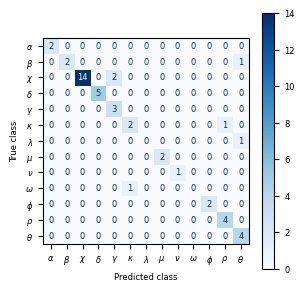

In [68]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

# import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (3.32, 3.32)#(6.97, 6.97)
plt.rcParams.update({'font.size': 6})


disp = plot_confusion_matrix(RF_clf, test_data.iloc[:,:-1], test_data.iloc[:,-1],
                         cmap=plt.cm.Blues,
                         normalize=None)
#     disp.ax_.set_title("{}".format(title))
disp.ax_.set_xlabel("Predicted class")
disp.ax_.set_ylabel("True class")
disp.ax_.set_yticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
disp.ax_.set_xticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
# plt.savefig('figures/classification_matrix_1s_83F1_fixedmu_shuffled_validation.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()


In [41]:
test_set_classifications = test_data.iloc[:,-1].to_frame()
test_set_classifications["Prediction"] = preds

In [42]:
misclass = test_set_classifications[test_set_classifications["Class"] != test_set_classifications["Prediction"]]

In [43]:
misclass

,Class,Prediction
40703-01-35-01,beta,theta
40703-01-24-00,kappa,rho
40703-01-25-00,kappa,rho
20402-01-36-01,lambda,theta
10408-01-42-00,chi,gamma
40703-01-20-03,chi,gamma
40703-01-29-01,omega,kappa


In [55]:
misclass_lc_n = 3
prob_predictions = RF_clf.predict_proba(test_data.loc[misclass.index[misclass_lc_n]].to_frame().T.iloc[:,:-1])[0]
predictions_order = np.argsort(prob_predictions)
for prob, clas in zip(prob_predictions[predictions_order], np.unique(test_data.iloc[:,-1])[predictions_order]):
    print(np.round(prob, decimals=4)*100, clas)

0.13 nu
1.16 alpha
2.25 rho
2.4 phi
2.46 mu
3.1300000000000003 gamma
3.6900000000000004 chi
5.029999999999999 omega
6.460000000000001 beta
9.19 delta
13.23 kappa
20.77 lambda
30.099999999999998 theta


In [50]:
with open('{}/1776_light_curves_1s_bin_errorfix.pkl'.format(data_dir), 'rb') as f:
    lcs = pickle.load(f)
with open('{}/1776_light_curves_1s_bin_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    ids = pickle.load(f)

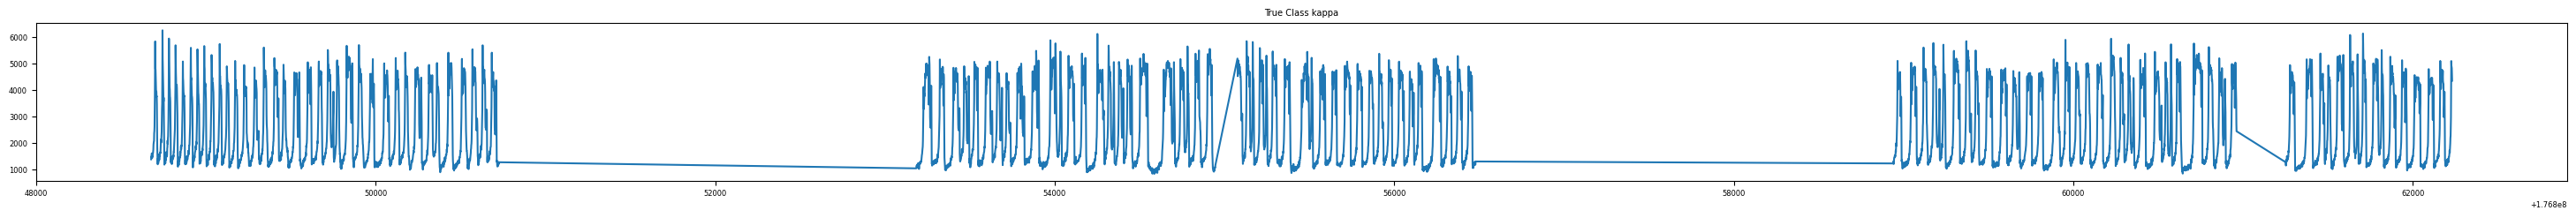

Predicted Class rho


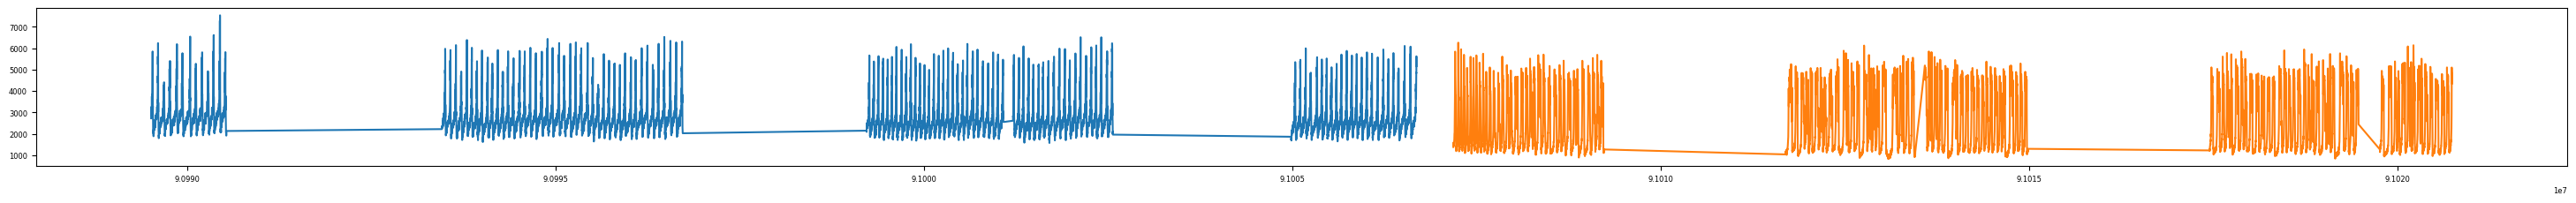

20402-01-03-00


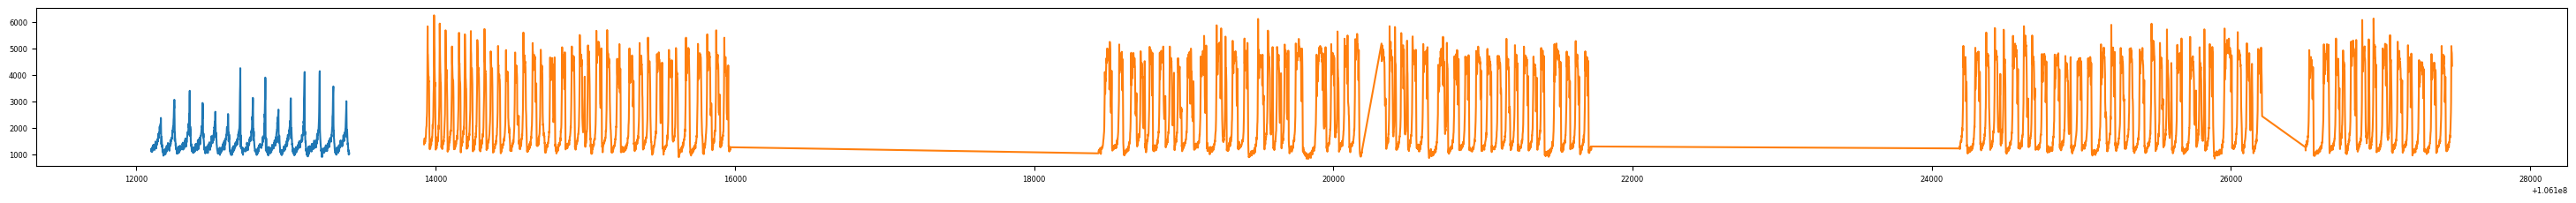

20402-01-27-02


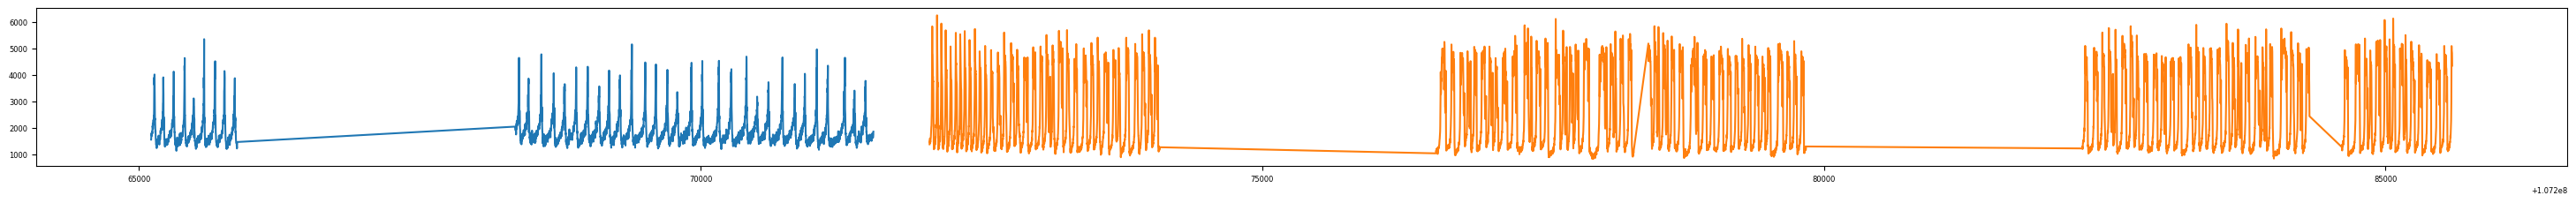

20402-01-30-00


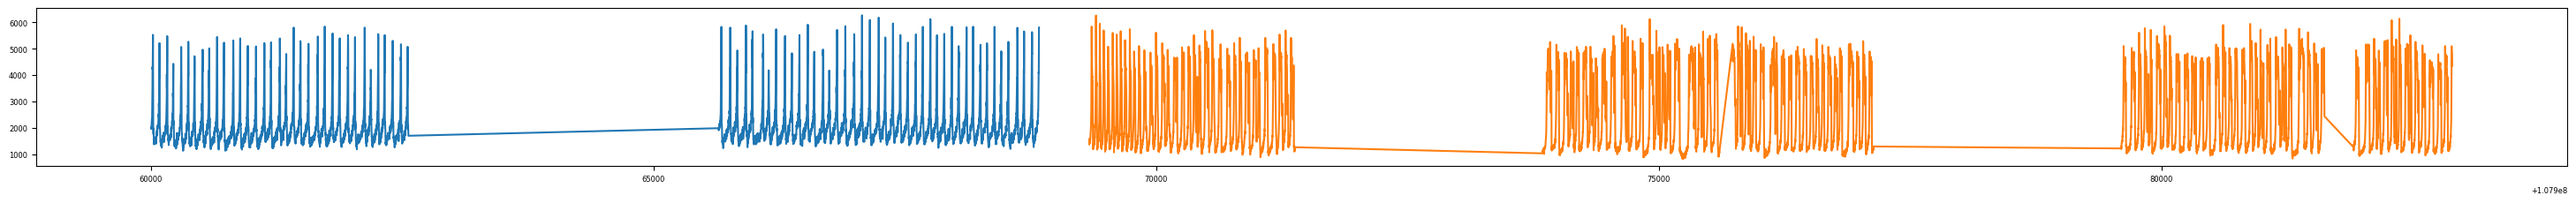

20402-01-31-00


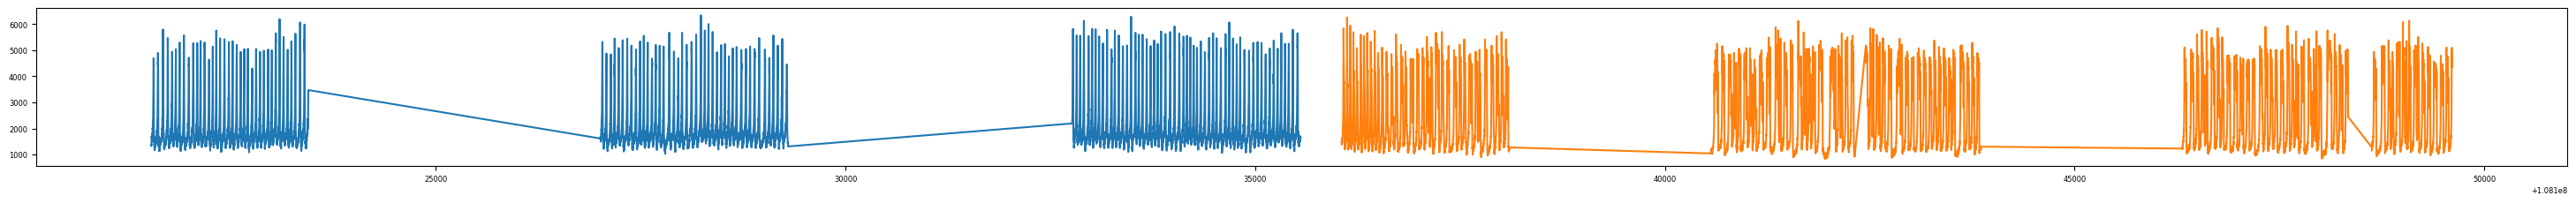

20402-01-31-01


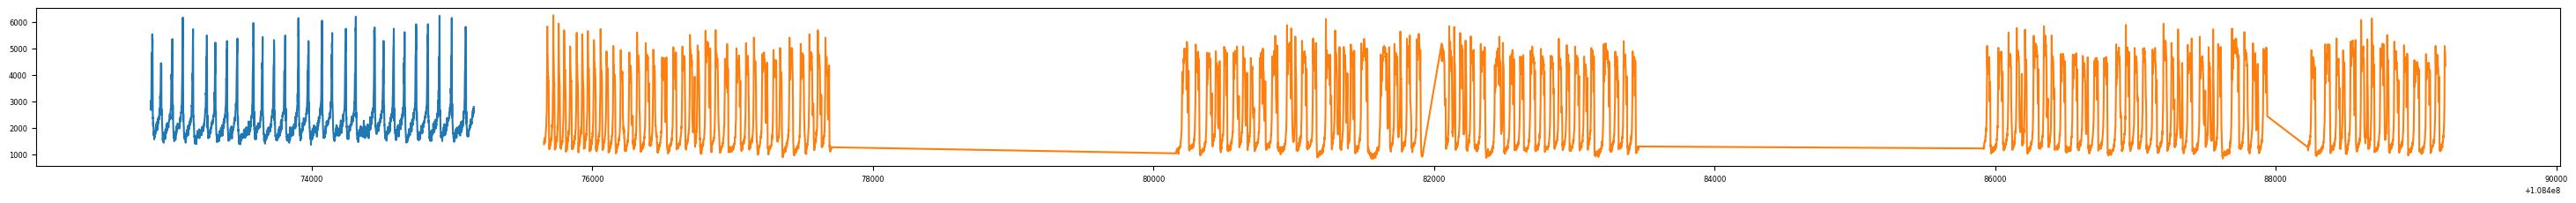

20402-01-32-00


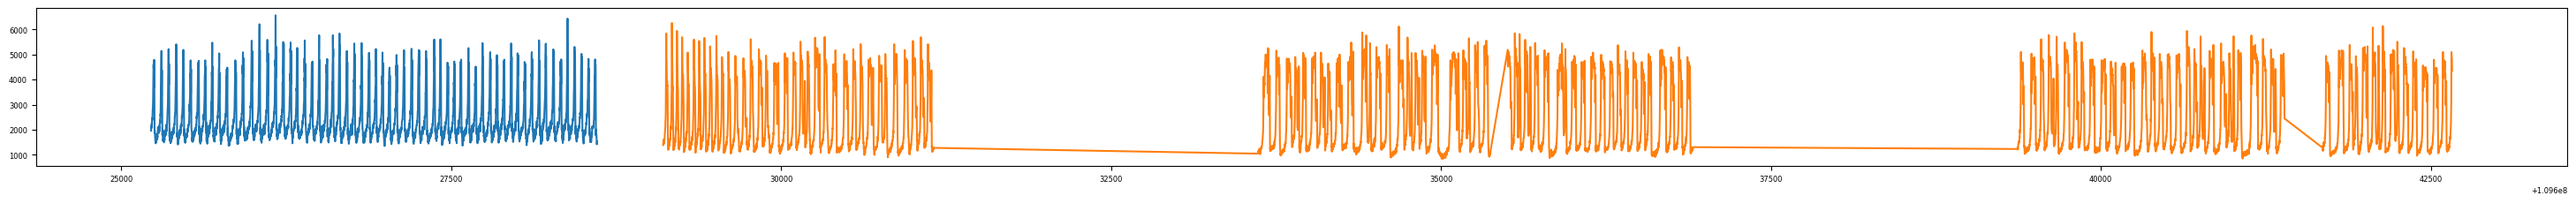

20402-01-34-01


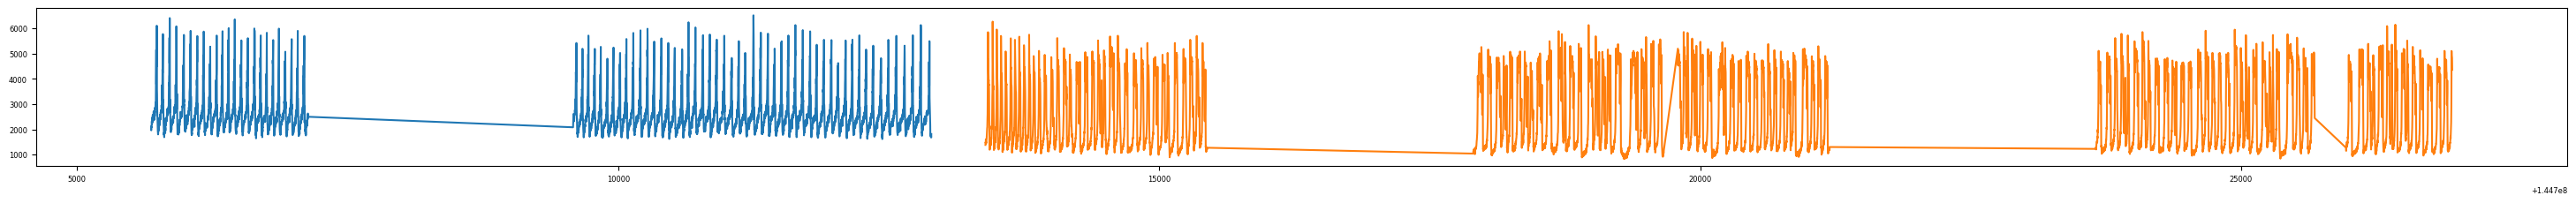

30703-01-27-00


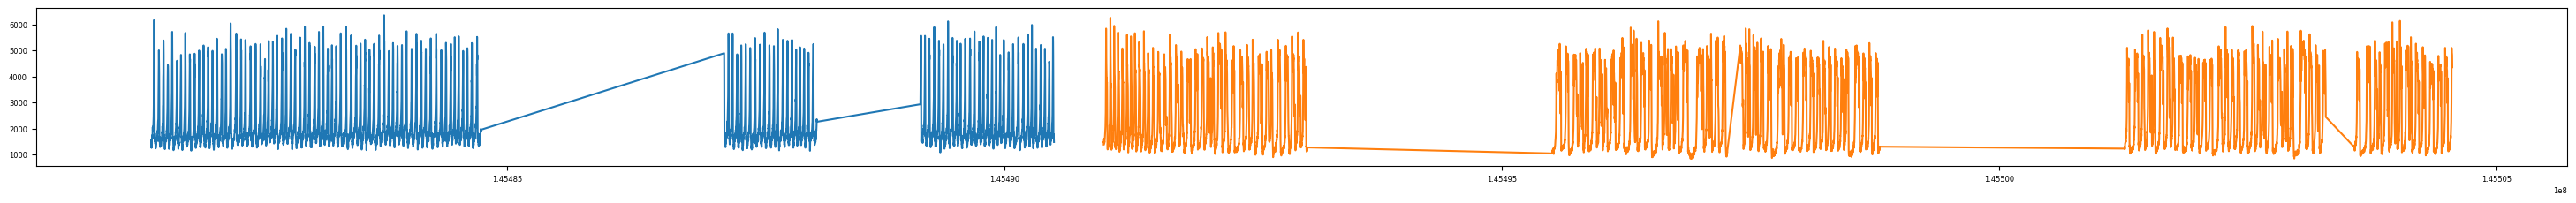

30703-01-28-00


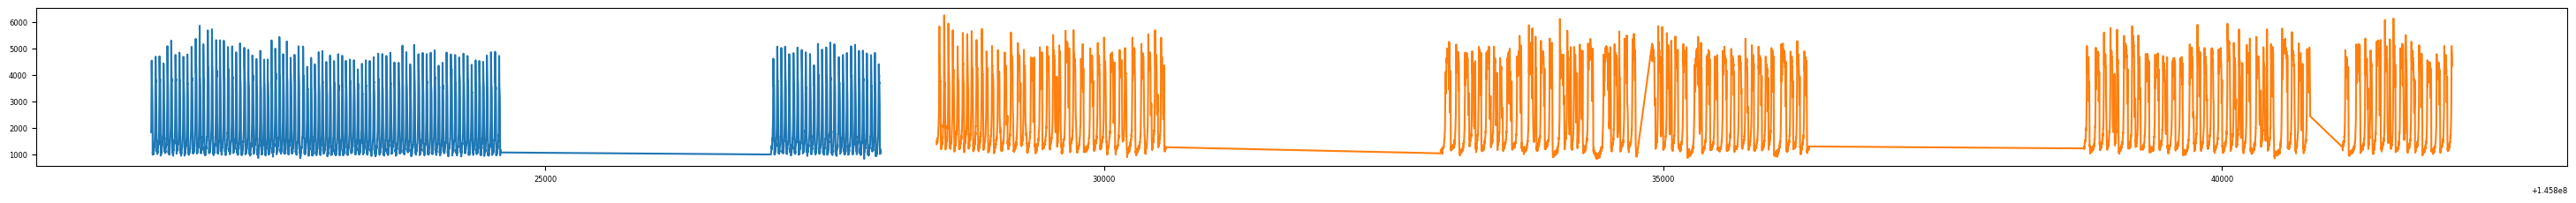

30703-01-29-00


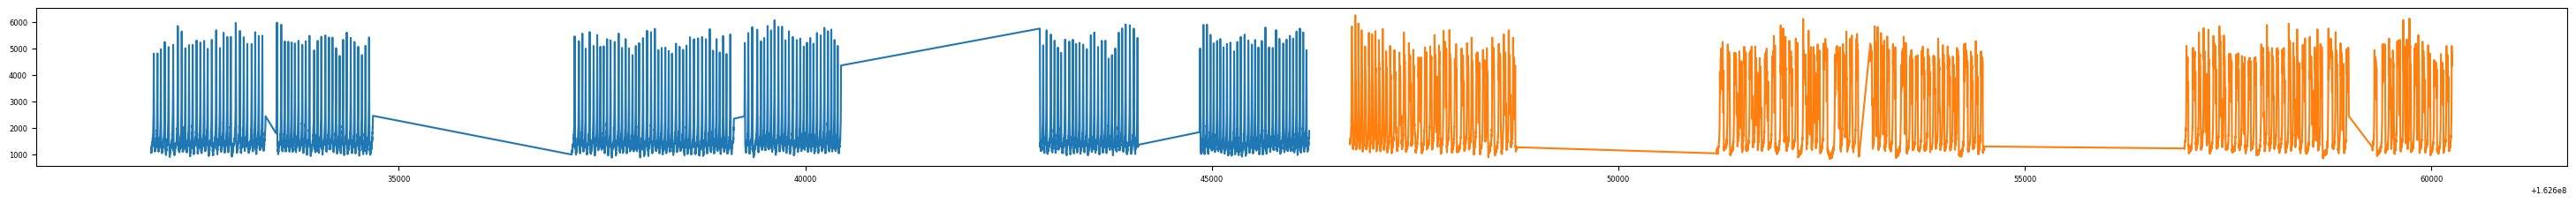

40703-01-07-00


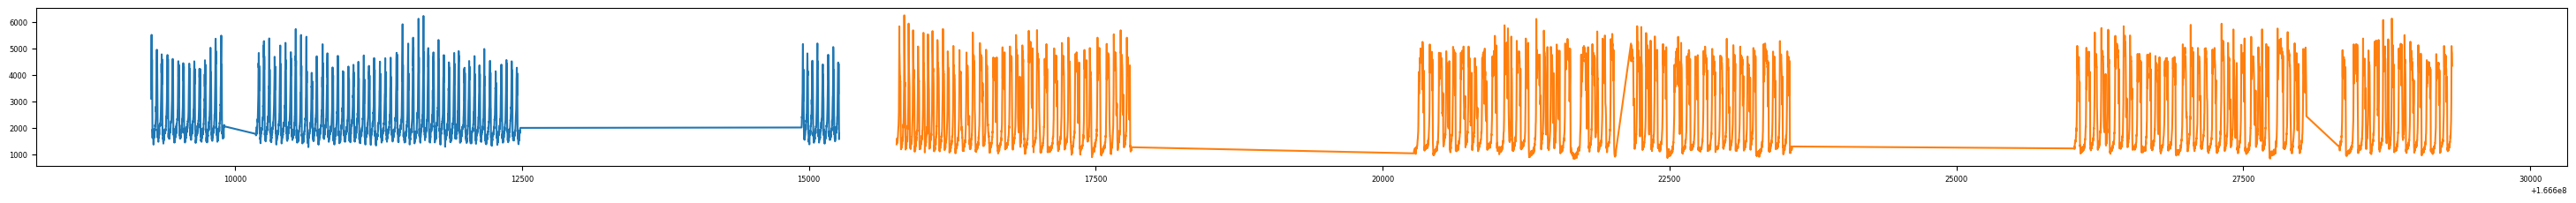

40403-01-05-02
True Class kappa


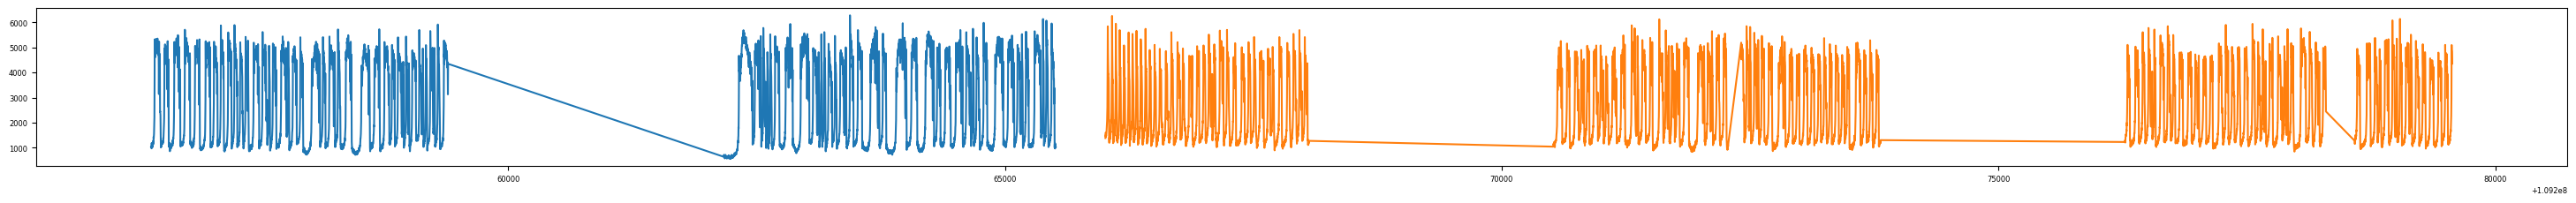

20402-01-33-00


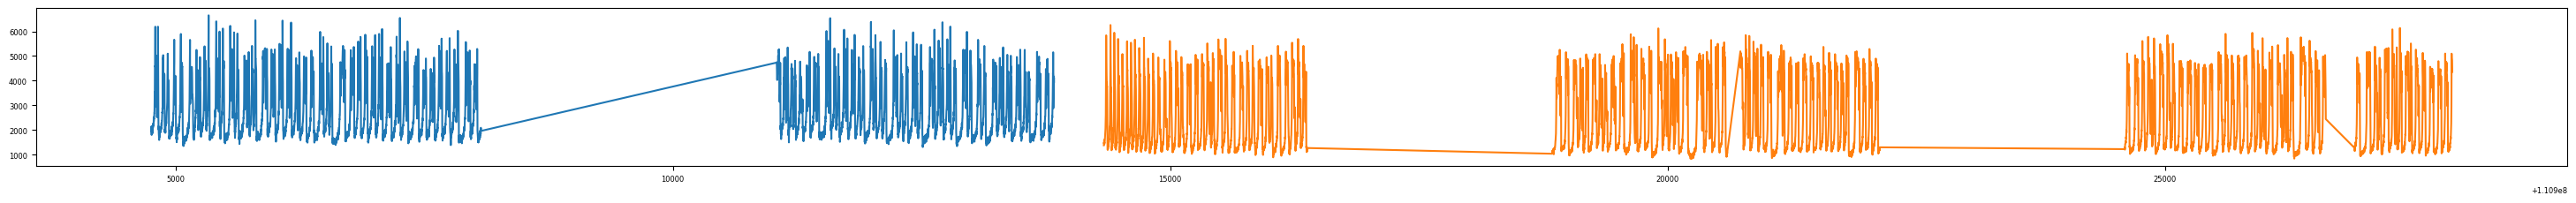

20402-01-35-00


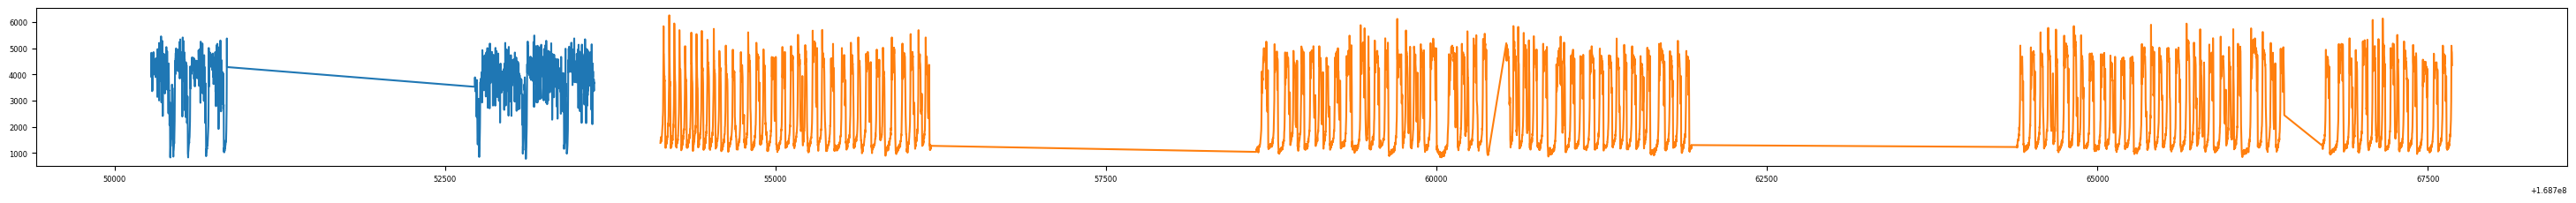

40703-01-14-00


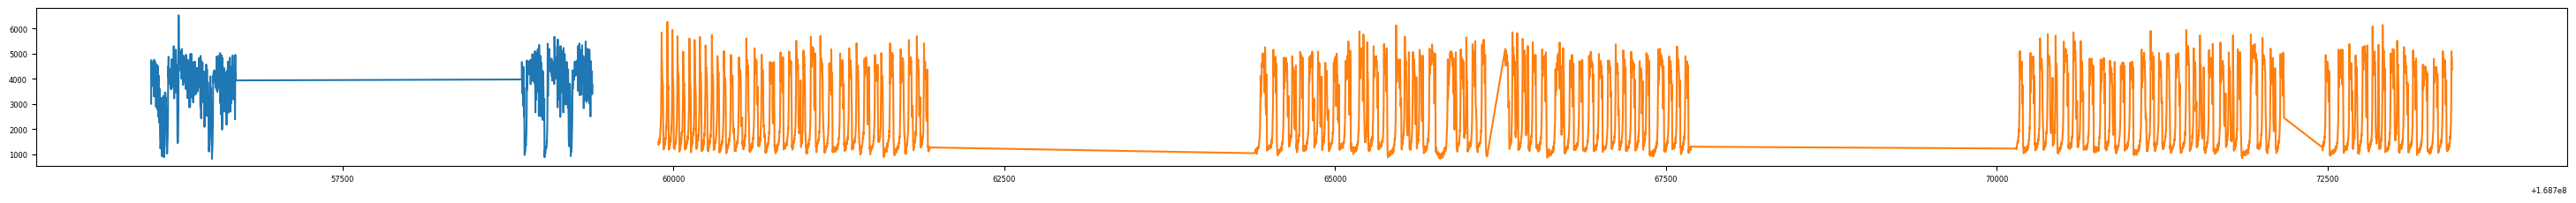

40703-01-14-01


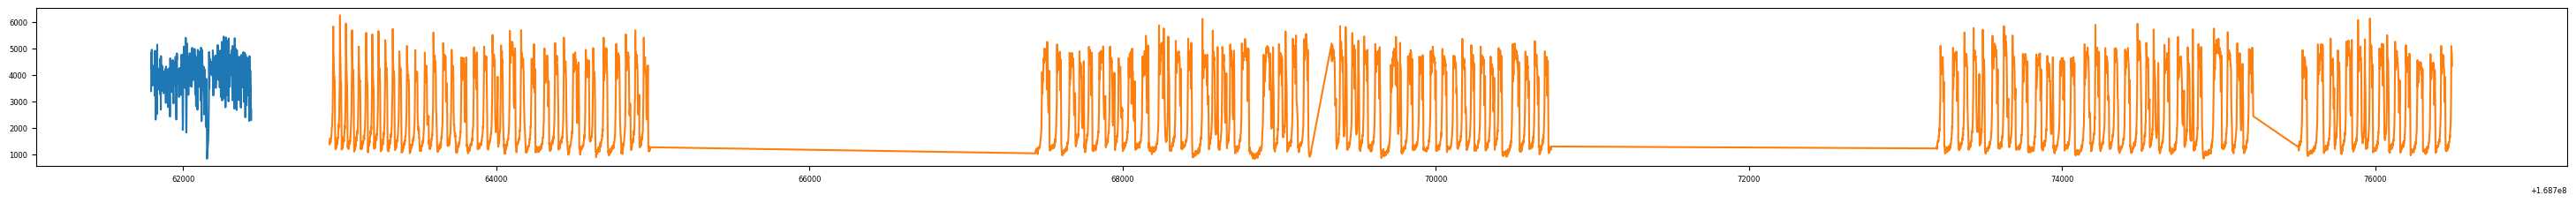

40703-01-14-02


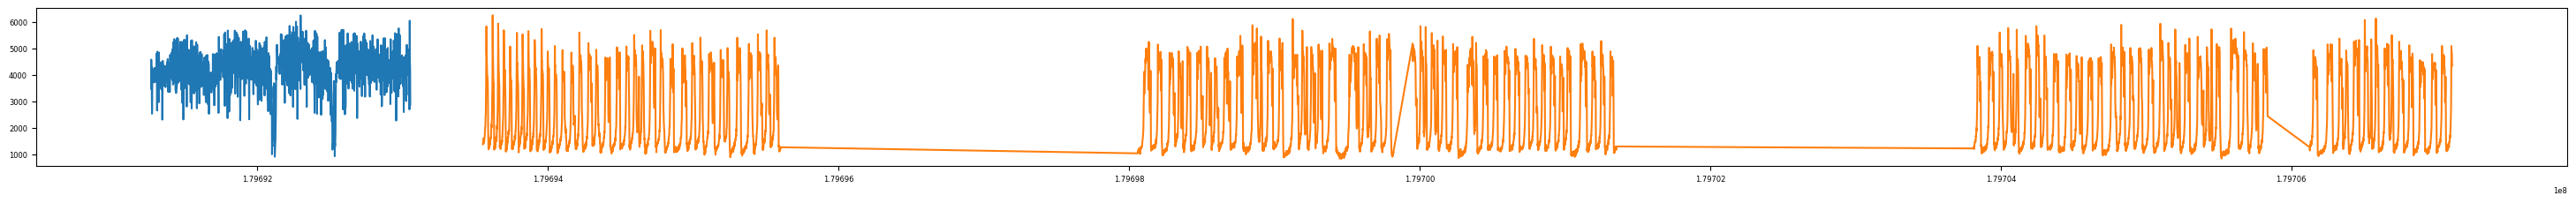

40703-01-30-00


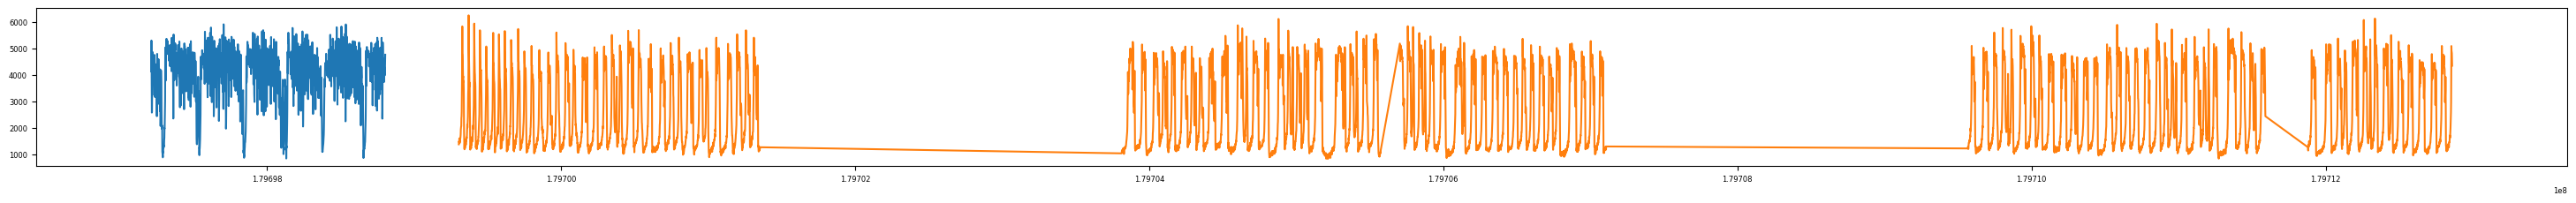

40703-01-30-01


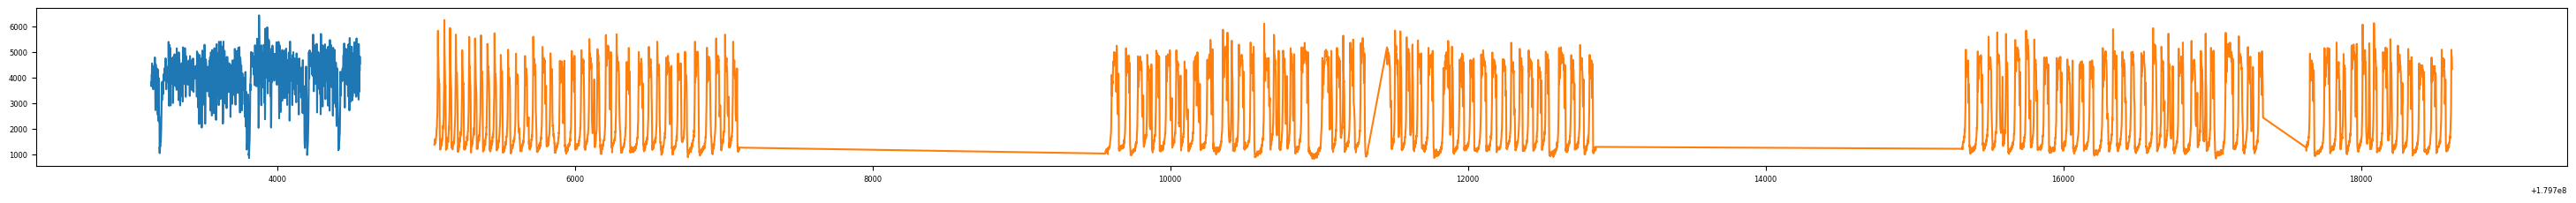

40703-01-30-02


In [53]:
plt.rcParams['figure.figsize'] = (36.97, 6.97*(1/3))
plt.rcParams.update({'font.size': 6})

misclass_lc_n = 2
misclass_lc = lcs[np.where(np.array(ids) == misclass.index[misclass_lc_n])[0][0]]
plt.plot(misclass_lc[0], misclass_lc[1])
plt.title("True Class {}".format(misclass.iloc[misclass_lc_n,:]["Class"]))
plt.show()

# list of ids of training observations for the class that was predicted
predicted_class_ids = [obid for obid in inv_ob_state[misclass.iloc[misclass_lc_n,:]["Prediction"]] if obid in train_data.index.values]
# list of ids of training observations for the true class of observation
true_class_ids = [obid for obid in inv_ob_state[misclass.iloc[misclass_lc_n,:]["Class"]] if obid in train_data.index.values]

print("Predicted Class", misclass.iloc[misclass_lc_n,:]["Prediction"])
for predicted_class_id in predicted_class_ids:
    predicted_class_lc = lcs[np.where(np.array(ids) == predicted_class_id)[0][0]]
    plt.plot(predicted_class_lc[0], predicted_class_lc[1])
    plt.plot(misclass_lc[0]-misclass_lc[0][0]+(predicted_class_lc[0][-1]+500), misclass_lc[1])
    plt.show()
    print(predicted_class_id)
    
print("True Class", misclass.iloc[misclass_lc_n,:]["Class"])
for true_class_id in true_class_ids:
    
    true_class_lc = lcs[np.where(np.array(ids) == true_class_id)[0][0]]
    plt.plot(true_class_lc[0], true_class_lc[1])
    plt.plot(misclass_lc[0]-misclass_lc[0][0]+(true_class_lc[0][-1]+500), misclass_lc[1])
    plt.show()
    print(true_class_id)

# 4s data

In [33]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
# import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from  sklearn.ensemble import RandomForestClassifier
from scipy import stats
# from sklearn.cluster import OPTICS
from copy import deepcopy

from scipy.stats import zscore
from scipy.spatial import distance


plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
def grid_search_classification_mu_shuffling(data_labels, data, train_set_ids, val_set_ids, seg_ObIDs):
    """
    prepare representations of observations based on their make up in terms of Gaussian mixture component contributions.
    test the representation as the feature set for classification task
    """
        
    # find GMM component labels for data
    data_GMMcomp_labels = data_labels
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)
        
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    
    
    obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows
    
    # add classification column
    obs_component_counts_df_comp["Class"] = "Unknown" 
    for k,v in ob_state.items():
        if v == "eta": v = "Unknown" ########## remove eta classifications, there are only two in the set of 1738 observations
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            
    obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"
    
    
    # create sets of shuffled (in as stratified manner) training and validaiton data 
    class_names, class_counts = np.unique(obs_component_counts_df_comp.loc[val_set_ids].loc[obs_component_counts_df_comp.loc[val_set_ids].iloc[:,-1] != "Unknown"].Class.values, return_counts=True)
    validation_sets = []
    training_sets = []

    for repetition in range(100):
        validation_set = []
        training_set = []
        for class_name, class_count in zip(class_names, class_counts):
            subset_ids = np.hstack((val_set_ids, train_set_ids))
            class_ids = obs_component_counts_df_comp.loc[subset_ids].loc[obs_component_counts_df_comp.loc[subset_ids].iloc[:,-1] == class_name].index.values
            np.random.seed(seed=repetition)
            validation_ids = np.random.choice(class_ids, size=class_count, replace=False)
            training_ids = np.array([x for x in class_ids if x not in validation_ids])

            validation_set.append(validation_ids)
            training_set.append(training_ids)

        validation_sets.append(np.concatenate(validation_set))
        training_sets.append(np.concatenate(training_set))

    #random forest hyperparameters
    max_depth_list = [None, 5, 10, 15, 25] # None 
    criterion_list= ["entropy", 'gini']

    reports = []
    
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for train_ids, val_ids in zip(training_sets, validation_sets):
                
                # training data
                train_data = obs_component_counts_df_comp.loc[train_ids] 
                # validation data
                val_data = obs_component_counts_df_comp.loc[val_ids]
                                
                RF_clf = RandomForestClassifier(random_state=0,
                                                criterion=criterion,
                                                class_weight="balanced",
                                                n_estimators=100,
                                                max_depth=max_depth, 
                                                min_samples_split= 2,
                                                min_samples_leaf = 1,
                                                n_jobs=35
                                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
                preds = RF_clf.predict(val_data.iloc[:,:-1])

                reports.append((precision_recall_fscore_support(val_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2],
                                accuracy_score(val_data.iloc[:,-1], preds),
                               (criterion,max_depth)))
    return reports

def merge_gaussian_component_labels(distance_matrix, observation_labels, sigma_threshold):
    """
        if mahalanobis distance between Gaussian components is smaller than the sigma_threshold, relabel the data within
    those components as belonging to a new, single cluster
    
    input:
        distance_matrix - square matrix containing distances between Gaussian component means, output of component_mahalanobis_distances function
        observation_labels - list of data labels corresponding to the Gaussian components
        sigma_threshold - threshold for the merger of Gaussian components. If distances between two component means are less then the threshold,
        (both when calculating from A to B and from B to A), the components will be treated as one cluster.
                            
    output
        new_observation_labels - modified observation_labels, where a new index was created for merged components, and both component indices were
        replaced with that new index
    

    uses the graph solution from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
    """
    # find pairs of components whose means are separated by mahalanobis distance smaller than the threshold (both ways)
    couples = np.array(np.where(((np.triu(distance_matrix)<sigma_threshold)&(np.triu(distance_matrix)>0))
      &(np.triu(distance_matrix.T)<sigma_threshold)&(np.triu(distance_matrix.T)>0))).T
    
    # build a graph of connections
    l = []
    for couple in couples:
        l.append([str(c) for c in couple])
    import networkx 
    from networkx.algorithms.components.connected import connected_components
    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G
    def to_edges(l):
        """ 
            treat `l` as a Graph and returns it's edges 
            to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current    
    G = to_graph(l)

    new_observation_labels = observation_labels
    # merge components
    for n_connection, connection in enumerate(connected_components(G)):
        node_indices=np.array([int(node) for node in connection])
#         new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
#                                           n_connection+np.unique(observation_labels).shape[0], new_observation_labels)
        new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
                                          node_indices[0], new_observation_labels)
        
    return new_observation_labels


In [35]:
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [36]:
with open('{}/lightcurve1738_train70_val10_test20.pkl'.format(data_dir), 'rb') as f:
    split_ob_ids = pickle.load(f)

In [37]:
# Load Gaussian mixture model which produced the minimum BIC with 1 second cadence data
with open("{}/GMM_279comps_model_2020-12-21_20-11-39_segments_468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl".format(data_dir), 'rb') as f:
    GMmodel_4s = pickle.load(f)

In [38]:
# load light curve segments
with open('{}/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-21_20-11-39.h5"
segments_dir = '../../../data_GRS1915/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 16 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [474471, 24]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [39]:
GMmodel_4s_labels = GMmodel_4s.predict(shape_moments)

In [40]:
with open("GM_comp_mahal_distances_4s.pkl".format(data_dir), 'rb') as f:
    GM_comp_mahal_distances_4s = pickle.load(f)

In [41]:
with open('{}/468202_len128_stride8_4sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

In [ ]:
no_components_premerger = np.unique(GMmodel_4s_labels).shape[0]

sigma_reports_list = []

for sigma_threshold in np.linspace(1.5,5,100):
    data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_4s, GMmodel_4s_labels, sigma_threshold)
    if (np.unique(data_labels).shape[0] < no_components_premerger) or len(sigma_reports_list)==0:
        no_components_premerger = np.unique(data_labels).shape[0]
        reports = grid_search_classification_mu_shuffling(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[1], seg_ObIDs)
        sigma_reports_list.append((sigma_threshold, reports))
        print(len(sigma_reports_list), sigma_threshold)
        clear_output(wait=True)
        
with open("sigmas100_reports_list_4s_100rng_criterion_depth_fixed_mergers_mu_withshuffling.pkl", 'wb') as f:
    pickle.dump(sigma_reports_list, f)

8 2.5606060606060606


In [43]:
rng_iterations= 100
treshold_avg_reports=[]
for threshold, report_list in sigma_reports_list:
    average_reports = []
    for set_i in range(int(len(report_list)/rng_iterations)):
        avg_f1=0
        avg_ac=0
        for rng_i in range(rng_iterations):
            avg_f1 += report_list[rng_i+(set_i*rng_iterations)][0]
            avg_ac += report_list[rng_i+(set_i*rng_iterations)][1]
        average_reports.append((avg_f1/rng_iterations,avg_ac/rng_iterations,(report_list[set_i*rng_iterations][2])))
    treshold_avg_reports.append((threshold,average_reports))

In [44]:
best_f1 = 0
best_result = []
for threshold, report_list in treshold_avg_reports:
    for report in report_list:
        if report[0] > best_f1:
            best_f1 = report[0]
            best_result = [threshold, report]
best_result

[2.8434343434343434, (0.7598162274445697, 0.8099999999999997, ('gini', 15))]

In [57]:
best_reports = sigma_reports_list[13][1][800:900]
(np.mean([x for x,y,z in best_reports]), np.std([x for x,y,z in best_reports]),
np.mean([y for x,y,z in best_reports]), np.std([y for x,y,z in best_reports]))

(0.7598162274445697,
 0.06754991847841661,
 0.8099999999999998,
 0.05581107446607574)